Summary of the features we're keeping to run this iteration.  Here are our splits:
# 
| Feature Group | Features |
|--------------|----------|
| ~~Quantified Metrics~~  | ~~impressions, clicks, CTR (to create), AverageWinPrice (CPM)~~ |
| ~~Channel & Location~~    | ~~channel, country, os, networkType, deviceType, CTR (to create), AverageWinPrice (CPM)~~ |
| ~~Quantified with Date & Profit~~        | ~~impressions, clicks, date, CTR (to create), AverageWinPrice (CPM), rate~~ |
| Advertiser & Product     | advMaturity, publisherCategory, advertiserCategory, product, subProduct, campaign, AverageWinPrice (CPM), rate |

In [2]:
!pip install numpy pandas matplotlib seaborn scikit-learn statsmodels openpyxl scipy


[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats


### Data Orientation

In [4]:
# split excel into multiple sheets
excel_file = 'data/raw/data.xlsx'
dir_name = 'data/raw'
xls = pd.ExcelFile(excel_file)

# load each sheet into a document
# Not overwrite
for sheet_name in xls.sheet_names:
    df = pd.read_excel(xls, sheet_name=sheet_name)
    csv_file = f"{dir_name}/{sheet_name.replace(' ', '_')}.csv"
    df.to_csv(csv_file, index=False)
    print(f"Saved sheet: {sheet_name}")


Saved sheet: historical data
Saved sheet: data_to_predict


In [5]:
# let's take a look at the data
historical_df = pd.read_csv('data/raw/historical_data.csv')
historical_df.head()


,impressions,clicks,eDate,channel,country,os,networkType,deviceType,publisherCategory,advertiserCategory,product,subProduct,campaign,advPackage,advMaturity,AverageWinPrice (CPM),rate
0,9,0,2017-12-09,inr,AU,android,3g,mobile,game_arcade,entertainment,600775.0,NaN,301059092,NaN,low maturity,1.404217,0.140000
1,6,0,2017-12-09,inr,ES,android,3g,mobile,game_casual,game_educational,640029.0,com.mohitdev.minebuild,300208158,NaN,low maturity,0.575850,0.030000
2,57,0,2017-12-09,inr,FR,android,3g,mobile,game_word,game_action,618417.0,com.etermax.apalabrados.lite,300038580,NaN,low maturity,0.052181,0.017333
3,22,2,2017-12-09,inr,IT,android,3g,mobile,game_adventure,entertainment,631206.0,com.secg.robocraft,301068023,NaN,low maturity,0.265992,0.021000
4,3,0,2017-12-09,inr,IT,android,3g,mobile,game_arcade,entertainment,632417.0,com.craftpixelstudio.cubelands,300222537,NaN,low maturity,0.676667,0.035000


In [6]:
# let's take a statistical summary of the data
historical_df.describe(include='all')


,impressions,clicks,eDate,channel,country,os,networkType,deviceType,publisherCategory,advertiserCategory,product,subProduct,campaign,advPackage,advMaturity,AverageWinPrice (CPM),rate
count,304629.000000,304629.000000,304629,304629,304618,304629,304629,304629,253895,299908,2.400300e+05,251823,302951,76388,304628,304629.000000,304629.000000
unique,NaN,NaN,8,5,53,2,4,2,47,38,NaN,875,370,65,12,NaN,NaN
top,NaN,NaN,2017-12-11,mpb,ZA,android,3g,mobile,game_puzzle,entertainment,NaN,1075264954,300798390,com.p74.player,low maturity,NaN,NaN
freq,NaN,NaN,40739,172588,48404,281007,204345,295987,31406,139492,NaN,2779,7335,10025,187226,NaN,NaN
mean,88.306632,0.761815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.370810e+08,NaN,NaN,NaN,NaN,0.207046,0.027231
std,1193.871334,12.364807,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.842803e+08,NaN,NaN,NaN,NaN,0.332051,0.027564
min,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.627600e+04,NaN,NaN,NaN,NaN,0.007190,0.003000
25%,2.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.872324e+06,NaN,NaN,NaN,NaN,0.050000,0.011000
50%,5.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.058059e+08,NaN,NaN,NaN,NaN,0.105240,0.020000
75%,21.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.219066e+09,NaN,NaN,NaN,NaN,0.207143,0.030000


In [7]:
data_to_predict_df = pd.read_csv('data/raw/data_to_predict.csv')
data_to_predict_df.head()

,sessionId,eDate,channel,country,os,networkType,deviceType,publisherCategory,advertiserCategory,product,subProduct,campaign,advPackage,advMaturity,rate
0,9705699729732200,2017-12-17,smt,BR,ios,unknown,mobile,NaN,education,130000706,319881193,301604736,com.kawecki.onemind,4+,0.010
1,12802690671750800,2017-12-17,smt,KH,android,3g,mobile,music & audio,entertainment,130167110,com.fundevs.app.mediaconverter,300988528,NaN,low maturity,0.008
2,21347409150256300,2017-12-17,smt,ID,ios,not_wifi,mobile,NaN,travel,130285027,com.alcaydevs.idlfree,300228923,com.go-jek.ios,4+,0.020
3,23329125091887800,2017-12-17,inr,RU,android,3g,mobile,social,music & audio,625569,drug.vokrug,301060338,com.p74.player,parental guidance,0.022
4,28266843791174100,2017-12-17,smt,DE,android,wifi,mobile,photography,NaN,130356465,com.photo.editor.cartoon,301011313,NaN,everyone,0.025


In [8]:
# dataframe dimensions
print(f"This dataframe has {historical_df.shape[0]} rows and {historical_df.shape[1]} columns.")
historical_df.info()

This dataframe has 304629 rows and 17 columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304629 entries, 0 to 304628
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   impressions            304629 non-null  int64  
 1   clicks                 304629 non-null  int64  
 2   eDate                  304629 non-null  object 
 3   channel                304629 non-null  object 
 4   country                304618 non-null  object 
 5   os                     304629 non-null  object 
 6   networkType            304629 non-null  object 
 7   deviceType             304629 non-null  object 
 8   publisherCategory      253895 non-null  object 
 9   advertiserCategory     299908 non-null  object 
 10  product                240030 non-null  float64
 11  subProduct             251823 non-null  object 
 12  campaign               302951 non-null  object 
 13  advPackage             76388 non-null   ob

In [9]:
# let's look at the distribution of our categorical variables
for column in historical_df.columns:
    if historical_df[column].dtype == 'object':
        print(f"Distribution of {column}:")
        print(historical_df[column].value_counts())
        print("\n")


Distribution of eDate:
eDate
2017-12-11    40739
2017-12-13    39743
2017-12-16    39000
2017-12-12    38743
2017-12-14    38546
2017-12-09    37791
2017-12-10    36090
2017-12-15    33977
Name: count, dtype: int64


Distribution of channel:
channel
mpb    172588
inr     72340
smt     49929
nxg      9495
rub       277
Name: count, dtype: int64


Distribution of country:
country
ZA    48404
JP    46055
ES    27456
RU    26017
PL    17768
FR    11087
IT     9515
BR     9087
MM     8869
AE     8582
US     5925
AU     5829
KR     5520
PA     4926
EG     4125
TN     4115
ID     3853
PT     3754
OM     3407
CL     3230
BH     2932
DE     2930
DZ     2799
GB     2793
MA     2558
NG     2534
HK     2471
KH     2435
VN     2382
KW     2341
TR     2064
NO     1942
MX     1675
RS     1665
NL     1586
IN     1536
SN     1271
DO     1245
SG     1121
PY      962
TH      916
HN      842
CA      738
MY      590
PH      577
AT      551
PK      512
HU      415
QA      247
TW      205
CR      130
SA     

### Visualizing our dataframes and eventual modeling

Predict CTR first, then use these predictions to predict CPM. This approach lets you refine the CTR predictions independently, which may improve the quality of CPM predictions.

If you’re not satisfied with the results, you could then try a multi-target model to see if simultaneous predictions capture hidden correlations better.



In [12]:
#create our CTR feature
historical_df['CTR'] = historical_df['clicks'] / historical_df['impressions']
channel_metrics_cols = ['channel', 'country', 'os', 'networkType', 'deviceType', 'CTR', 'AverageWinPrice (CPM)']

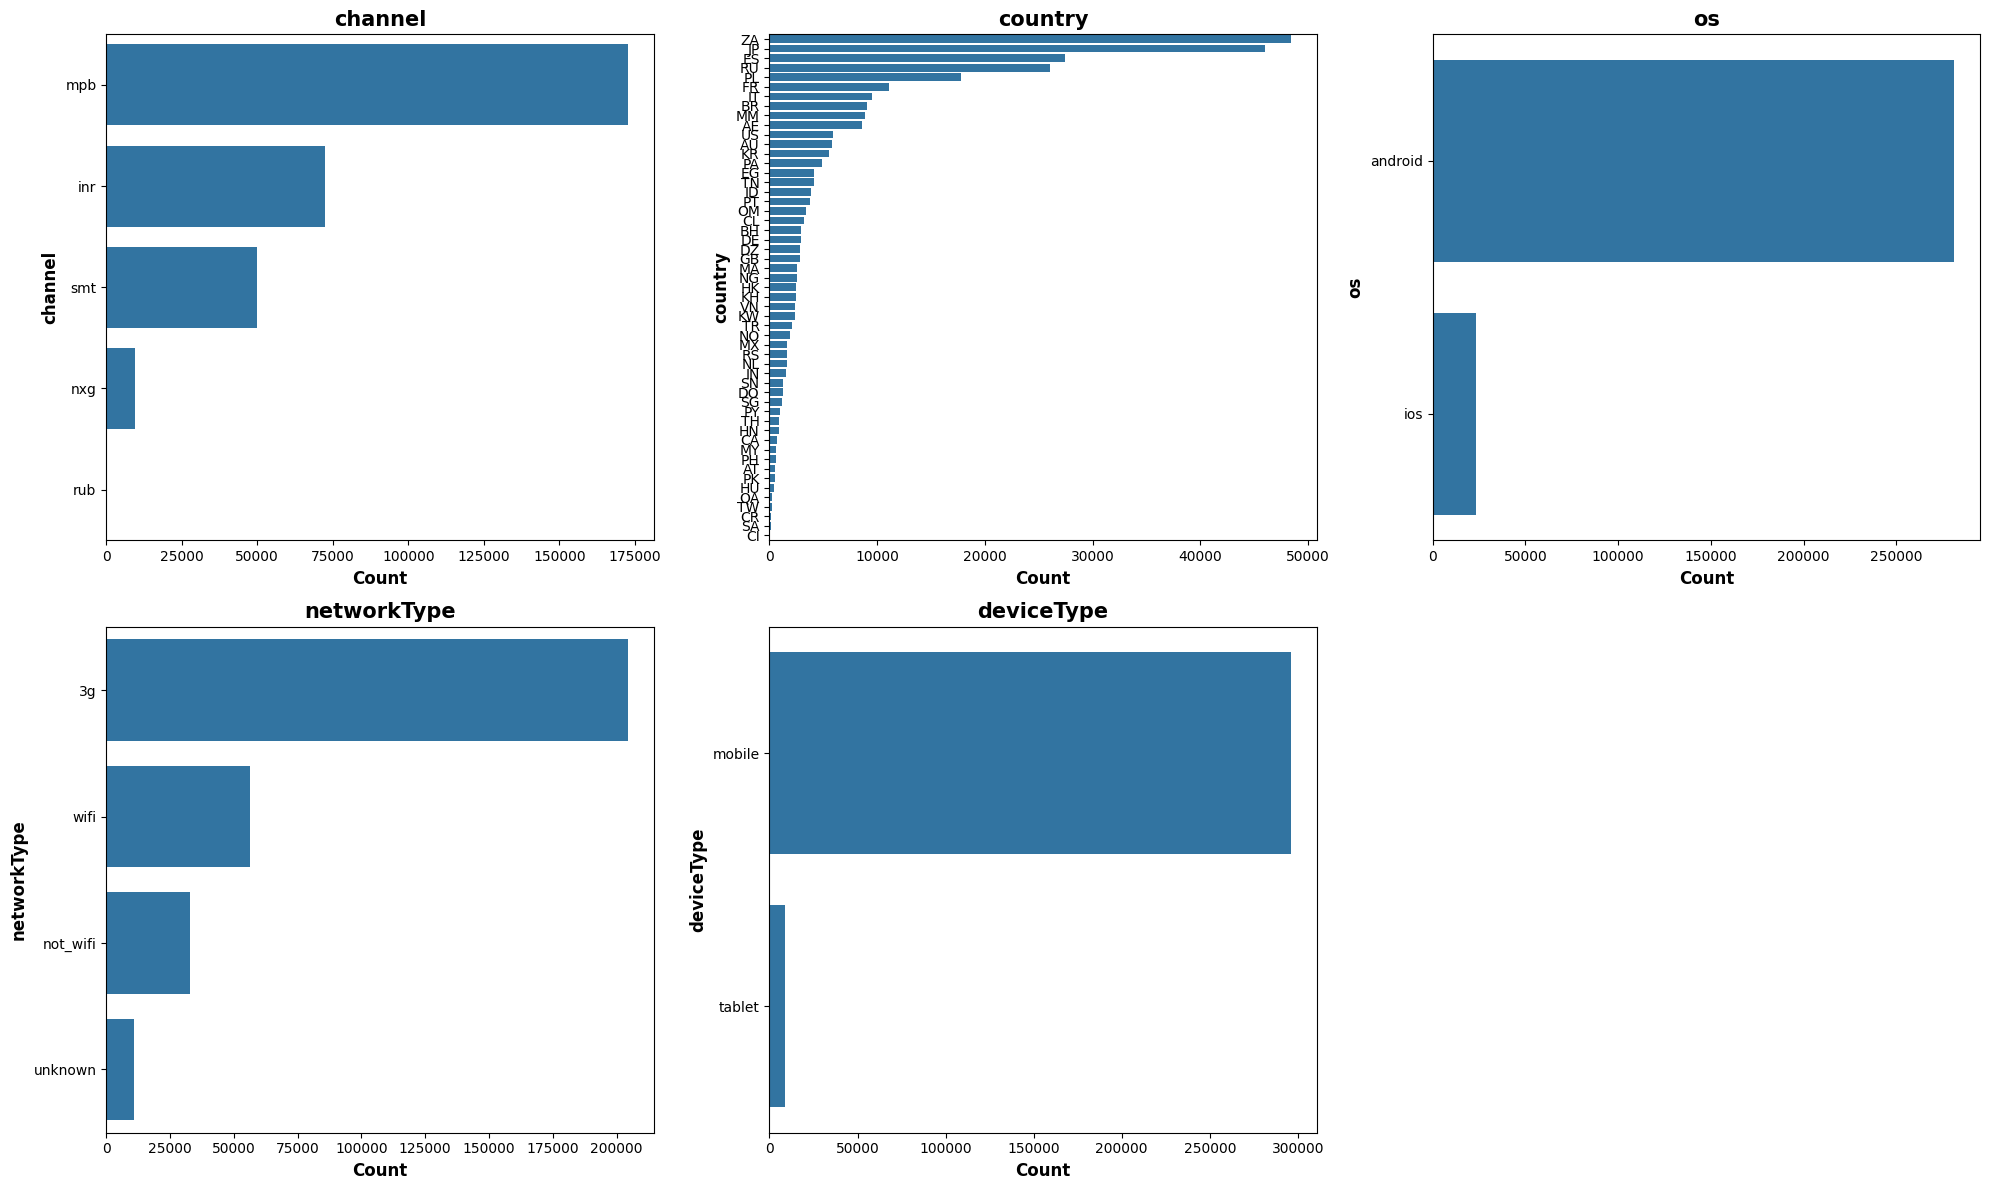

In [20]:
plt.figure(figsize=(20, 12))

for i, col in enumerate(channel_metrics_cols[:5], 1):
    plt.subplot(2, 3, i)
    if historical_df[col].dtype == 'object':
        # For categorical variables
        sns.countplot(y=col, data=historical_df, order=historical_df[col].value_counts().index)
        plt.title(f"{col}", fontsize=15, fontweight='bold')
        plt.xlabel("Count", fontsize=12, fontweight='bold')
        plt.ylabel(col, fontsize=12, fontweight='bold')
    else:
        # For numerical variables
        sns.histplot(historical_df[col], kde=True)
        plt.title(f"Distribution - {col}", fontsize=15, fontweight='bold')
        plt.xlabel(col, fontsize=12, fontweight='bold')
        plt.ylabel("Count", fontsize=12, fontweight='bold')
    
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

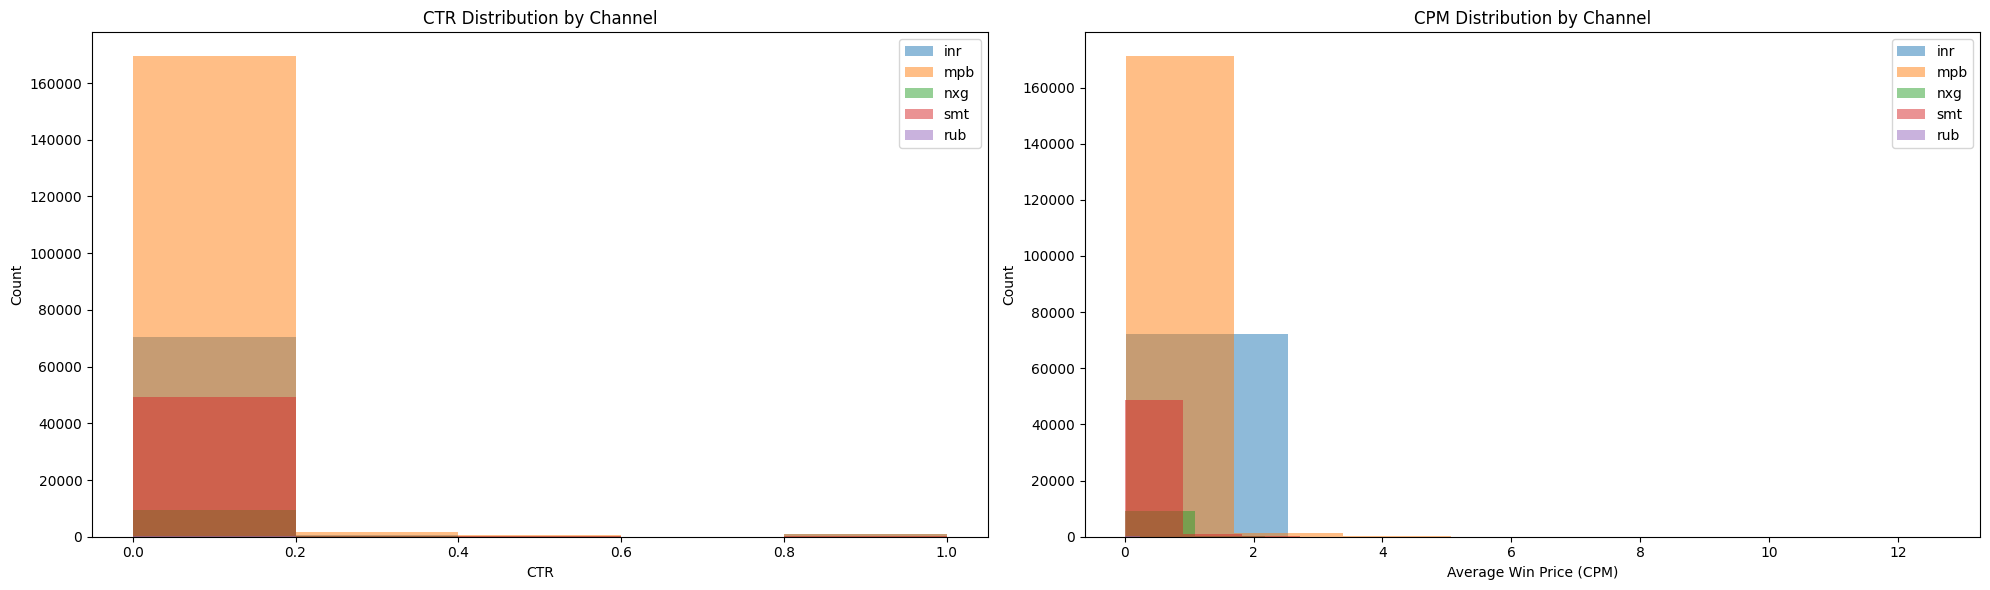

In [23]:
# let's display the distribution of our channel metrics

unique_channel = historical_df['channel'].unique()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot CTR distribution
for channel in unique_channel:
    data = historical_df[historical_df['channel'] == channel]
    ax1.hist(data['CTR'], bins=5, label=channel, alpha=0.5)

ax1.set_title('CTR Distribution by Channel')
ax1.set_xlabel('CTR')
ax1.set_ylabel('Count')
ax1.legend()

# Plot CPM distribution 
for channel in unique_channel:
    data = historical_df[historical_df['channel'] == channel]
    ax2.hist(data['AverageWinPrice (CPM)'], bins=5, label=channel, alpha=0.5)

ax2.set_title('CPM Distribution by Channel')
ax2.set_xlabel('Average Win Price (CPM)')
ax2.set_ylabel('Count')
ax2.legend()

plt.tight_layout()
plt.show()


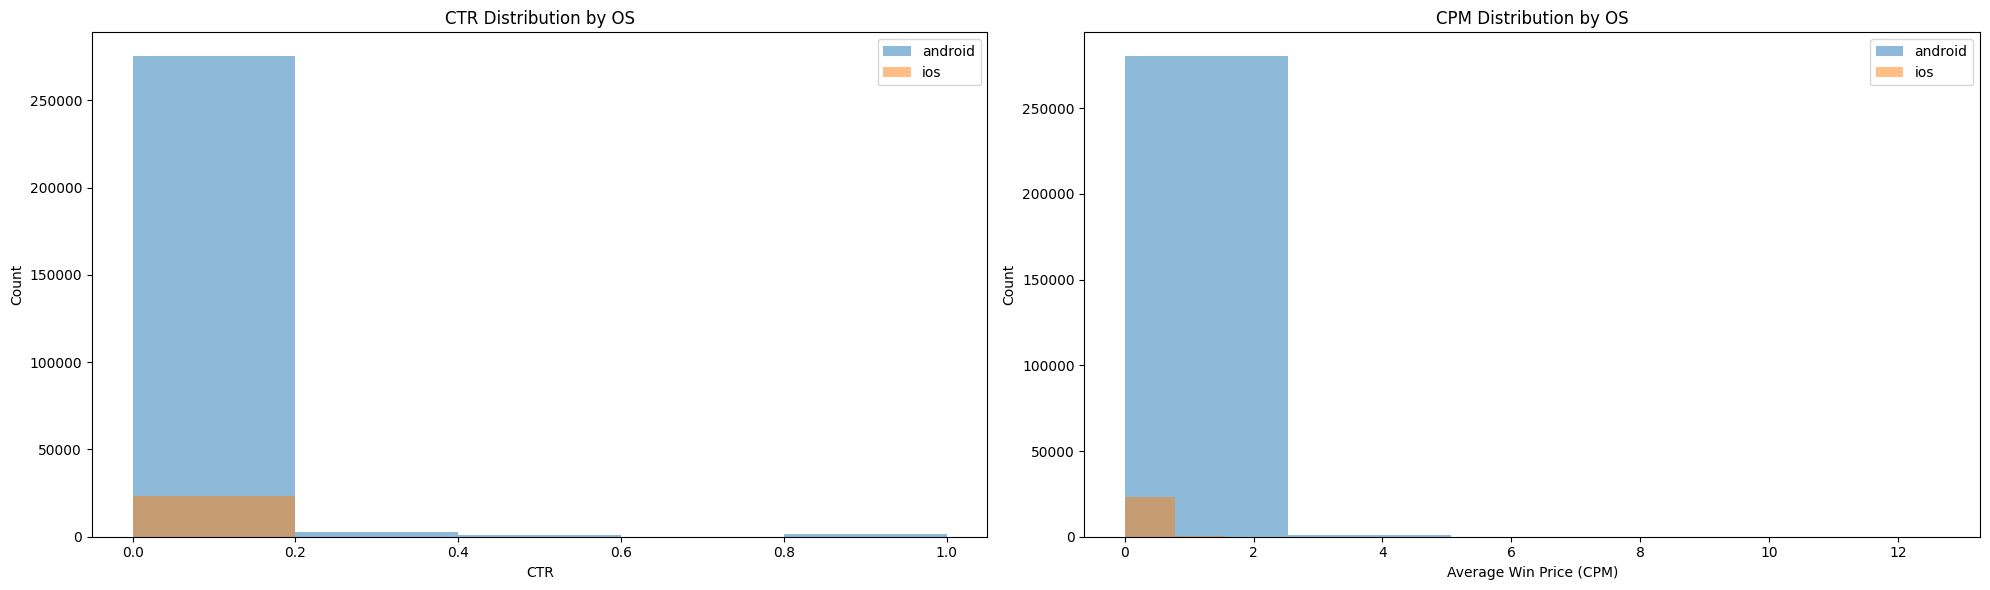

In [24]:
# let's display the distribution of our channel metrics

unique_os = historical_df['os'].unique()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot CTR distribution
for os in unique_os:
    data = historical_df[historical_df['os'] == os]
    ax1.hist(data['CTR'], bins=5, label=os, alpha=0.5)

ax1.set_title('CTR Distribution by OS')
ax1.set_xlabel('CTR')
ax1.set_ylabel('Count')
ax1.legend()

# Plot CPM distribution 
for os in unique_os:
    data = historical_df[historical_df['os'] == os]
    ax2.hist(data['AverageWinPrice (CPM)'], bins=5, label=os, alpha=0.5)

ax2.set_title('CPM Distribution by OS')
ax2.set_xlabel('Average Win Price (CPM)')
ax2.set_ylabel('Count')
ax2.legend()

plt.tight_layout()
plt.show()


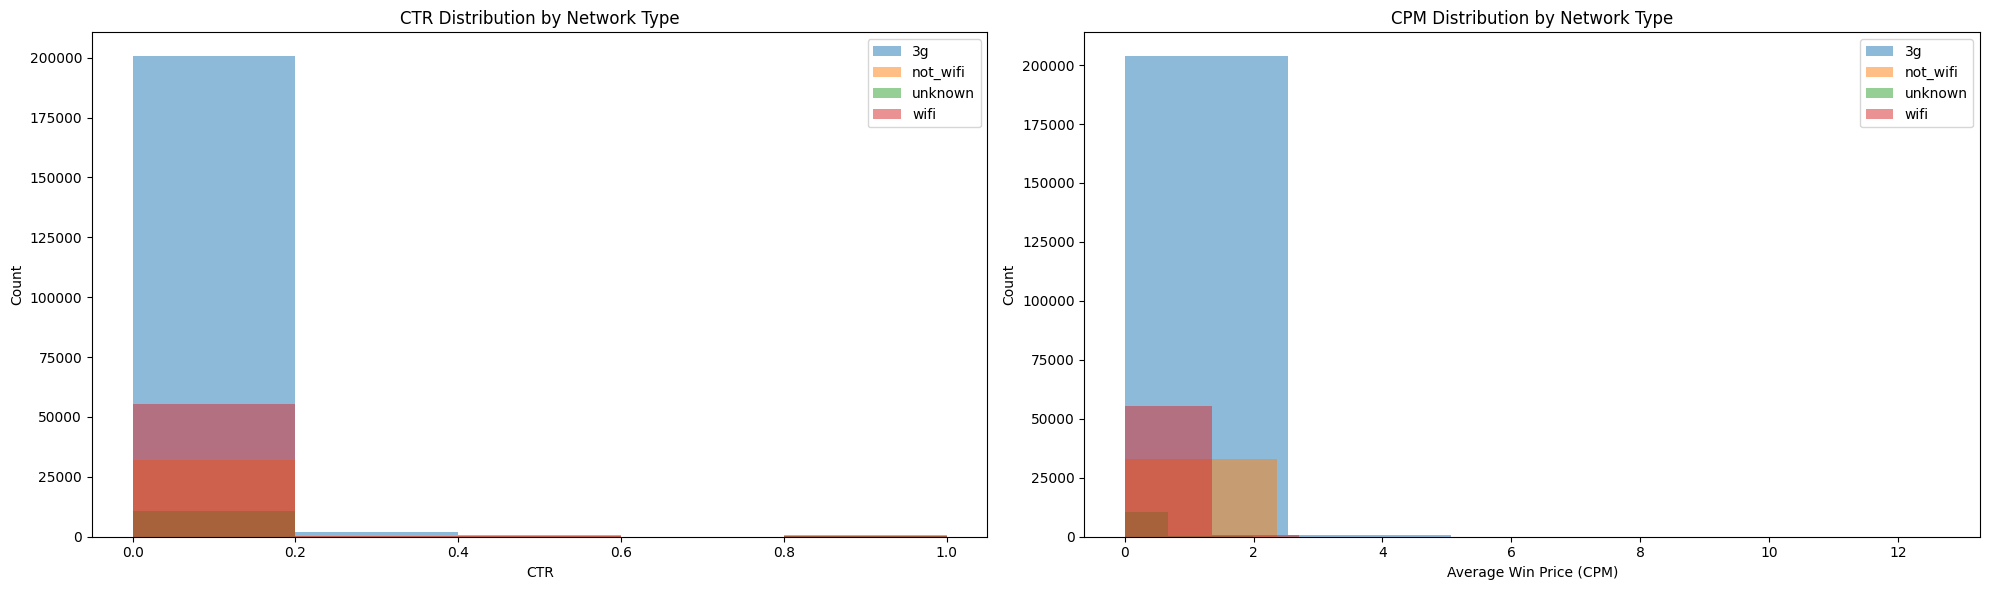

In [25]:
# let's display the distribution of our channel metrics

unique_networkType = historical_df['networkType'].unique()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot CTR distribution
for networkType in unique_networkType:
    data = historical_df[historical_df['networkType'] == networkType]
    ax1.hist(data['CTR'], bins=5, label=networkType, alpha=0.5)

ax1.set_title('CTR Distribution by Network Type')
ax1.set_xlabel('CTR')
ax1.set_ylabel('Count')
ax1.legend()

# Plot CPM distribution 
for networkType in unique_networkType:
    data = historical_df[historical_df['networkType'] == networkType]
    ax2.hist(data['AverageWinPrice (CPM)'], bins=5, label=networkType, alpha=0.5)

ax2.set_title('CPM Distribution by Network Type')
ax2.set_xlabel('Average Win Price (CPM)')
ax2.set_ylabel('Count')
ax2.legend()

plt.tight_layout()
plt.show()


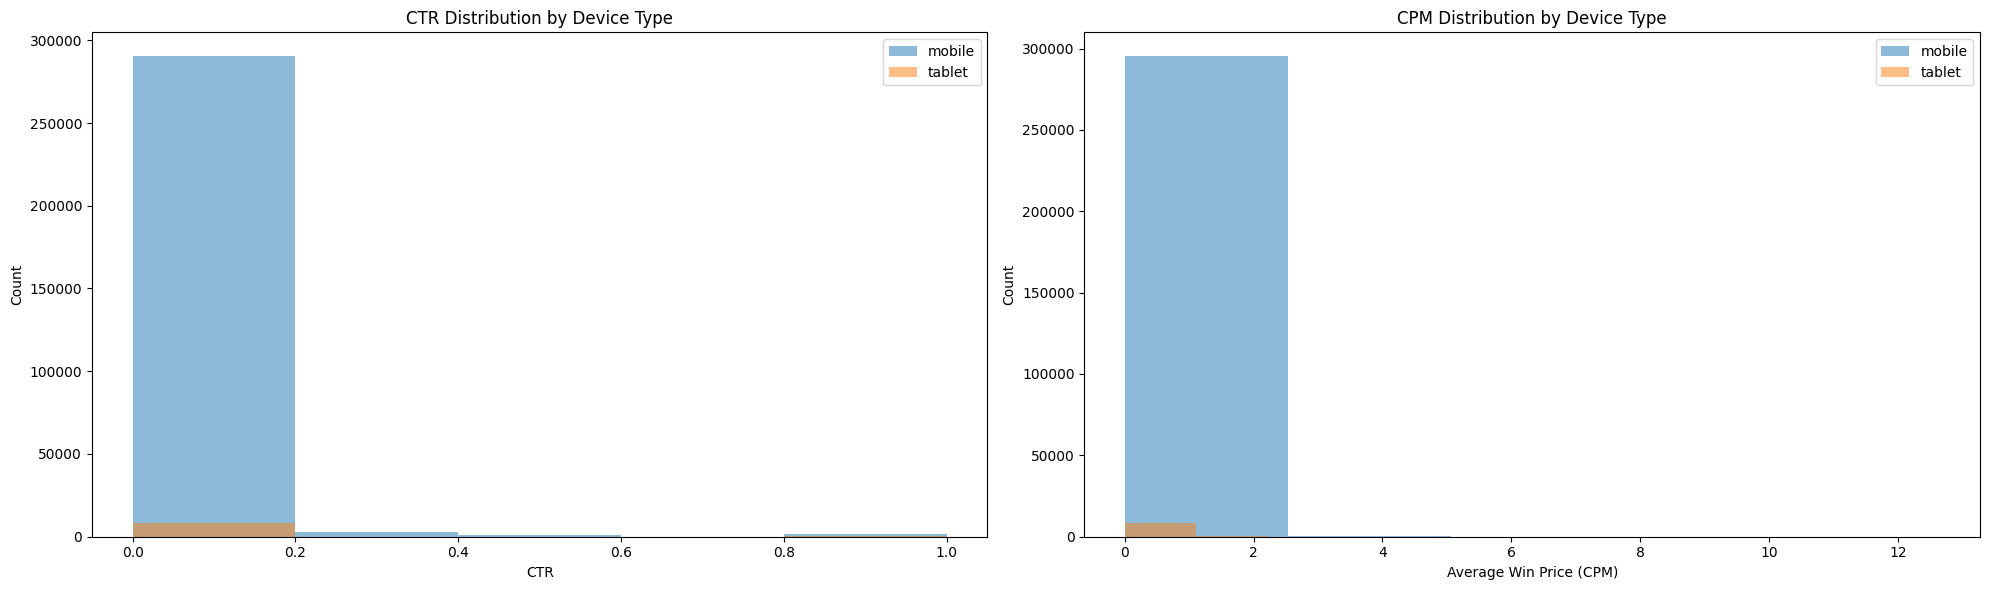

In [26]:
# let's display the distribution of our channel metrics

unique_deviceType = historical_df['deviceType'].unique()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot CTR distribution
for deviceType in unique_deviceType:
    data = historical_df[historical_df['deviceType'] == deviceType]
    ax1.hist(data['CTR'], bins=5, label=deviceType, alpha=0.5)

ax1.set_title('CTR Distribution by Device Type')
ax1.set_xlabel('CTR')
ax1.set_ylabel('Count')
ax1.legend()

# Plot CPM distribution 
for deviceType in unique_deviceType:
    data = historical_df[historical_df['deviceType'] == deviceType]
    ax2.hist(data['AverageWinPrice (CPM)'], bins=5, label=deviceType, alpha=0.5)

ax2.set_title('CPM Distribution by Device Type')
ax2.set_xlabel('Average Win Price (CPM)')
ax2.set_ylabel('Count')
ax2.legend()

plt.tight_layout()
plt.show()


### Preprocessing & EDA 

Removing outliers, missing values, etc.

Encoding of categorical variables to numbers

Declaring our target features.



In [27]:
# create our new dataframe with our features from channel_metrics_cols
historical_eda_df = historical_df[channel_metrics_cols]
historical_eda_df.head()


,channel,country,os,networkType,deviceType,CTR,AverageWinPrice (CPM)
0,inr,AU,android,3g,mobile,0.000000,1.404217
1,inr,ES,android,3g,mobile,0.000000,0.575850
2,inr,FR,android,3g,mobile,0.000000,0.052181
3,inr,IT,android,3g,mobile,0.090909,0.265992
4,inr,IT,android,3g,mobile,0.000000,0.676667


In [28]:
# missing values summary
def missing_values_summary(df): 
    return pd.DataFrame(
        zip(
            df.columns,
            df.isna().any(),
            (df.isna().sum() / df.shape[0] * 100).round(2),
            df.dtypes,
            df.apply(lambda x: x.sample(n=1).iloc[0] if len(x) > 0 else None)),
        columns=['Column', 'Has Missing Values', '% Missing Values', 'Feature Type', 'Sample Value']
    )

missing_values_summary(historical_eda_df)


,Column,Has Missing Values,% Missing Values,Feature Type,Sample Value
0,channel,False,0.0,object,mpb
1,country,True,0.0,object,IT
2,os,False,0.0,object,android
3,networkType,False,0.0,object,3g
4,deviceType,False,0.0,object,mobile
5,CTR,False,0.0,float64,0.009709
6,AverageWinPrice (CPM),False,0.0,float64,0.06446


### Outlier Analysis

Looking at what we have above it's clear that we have a lot of outliers in our data.  We will need to clean this up for our modeling.  When we look at RATE it's a narrow range of numbers that's close to what we want.  But looking at impressive and win price we have outliers that are skewing our data.  We will need to clean this up for our modeling.

In [31]:
# here is where we will pass in our different tiny-dataframes into our created methods for visualization
historical_eda_df.describe().T

,count,mean,std,min,25%,50%,75%,max
CTR,304629.0,0.015350,0.089528,0.00000,0.00,0.00000,0.000000,1.00000
AverageWinPrice (CPM),304629.0,0.207046,0.332051,0.00719,0.05,0.10524,0.207143,12.64182


#### Ok we'll keep our outliers for now.  Let's see how the results come out and we'll move on to looking at the power of the correlations with this tiny-dataframe.

In [38]:
# Categorical Encoding
# Define a function to perform target encoding
def target_encode(df, target_col, category_col):
    mean_target = df.groupby(category_col)[target_col].mean()
    df[category_col + '_encoded'] = df[category_col].map(mean_target)
    return df

In [57]:
# Define categorical columns
categorical_cols = ['channel', 'country', 'os', 'networkType', 'deviceType']

# Create a copy of the dataframe for CTR analysis
ctr_df = historical_eda_df.copy()
ctr_df = ctr_df.dropna(subset=categorical_cols)
ctr_df.isna().sum()

channel                  0
country                  0
os                       0
networkType              0
deviceType               0
CTR                      0
AverageWinPrice (CPM)    0
dtype: int64

In [61]:
for col in categorical_cols:
    train_data = target_encode(ctr_df, 'CTR', col)

#drop the original categorical columns
X = train_data.drop(columns=categorical_cols)
X = X.drop(columns=['CTR', 'AverageWinPrice (CPM)'])

y = train_data['CTR']

X.head()

,channel_encoded,country_encoded,os_encoded,networkType_encoded,deviceType_encoded
0,0.022398,0.007934,0.016101,0.014122,0.014868
1,0.022398,0.010777,0.016101,0.014122,0.014868
2,0.022398,0.015271,0.016101,0.014122,0.014868
3,0.022398,0.012749,0.016101,0.014122,0.014868
4,0.022398,0.012749,0.016101,0.014122,0.014868


In [62]:
# Stratified samplign for cross validation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score

# Create bins for CTR (our target variable) since StratifiedKFold requires categorical labels
# We bin it because CTR is continuous and StratifiedKFold needs discrete categories
y_binned = pd.qcut(y, q=5, labels=False, duplicates='drop')  # Split CTR into 5 equal-sized bins

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

mse_fold_scores = []
r2_fold_scores = []

for fold_num, (train_index, test_index) in enumerate(skf.split(X, y_binned)):
    print(f"Fold {fold_num + 1}")
    
    X_train_fold = X.iloc[train_index]
    X_test_fold = X.iloc[test_index]

    y_train_fold = y.iloc[train_index]
    y_test_fold = y.iloc[test_index]

    print(f"Training size: {len(X_train_fold)}, Validation size: {len(X_test_fold)}")
    print(f"Average CTR in training: {y_train_fold.mean():.4f}")
    print(f"Average CTR in validation: {y_test_fold.mean():.4f}")

    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    model.fit(X_train_fold, y_train_fold)

    y_pred = model.predict(X_test_fold)

    mse_fold_scores.append(mean_squared_error(y_test_fold, y_pred))
    r2_fold_scores.append(r2_score(y_test_fold, y_pred))

# Calculate average cross-validation score
print("\n")
print(f'Average cross-validation MSE: {np.mean(mse_fold_scores)}')
print(f"Average R2 score across folds: {np.mean(r2_fold_scores):.4f}")



Fold 1
Training size: 243694, Validation size: 60924
Average CTR in training: 0.0154
Average CTR in validation: 0.0152
Fold 2
Training size: 243694, Validation size: 60924
Average CTR in training: 0.0154
Average CTR in validation: 0.0152
Fold 3
Training size: 243694, Validation size: 60924
Average CTR in training: 0.0153
Average CTR in validation: 0.0154
Fold 4
Training size: 243695, Validation size: 60923
Average CTR in training: 0.0153
Average CTR in validation: 0.0155
Fold 5
Training size: 243695, Validation size: 60923
Average CTR in training: 0.0153
Average CTR in validation: 0.0154



Average cross-validation MSE: 0.007840938276672487
Average R2 score across folds: 0.0217
